In [1]:
import gpxpy
import mplleaflet
import pandas as pd
import numpy as np
from pykalman import KalmanFilter

import matplotlib.pyplot as plt
#plt.rcParams['axes.xmargin'] = 0.1
#plt.rcParams['axes.ymargin'] = 0.1
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

%load_ext autoreload
%autoreload 2

In [2]:
with open('../gpx/3-laender-giro.gpx') as fh:
    gpx_file = gpxpy.parse(fh)
    
segment = gpx_file.tracks[0].segments[0]

### Let's try to correct some unrealistic things like

In [3]:
segment.get_uphill_downhill()

UphillDownhill(uphill=4446.100000000043, downhill=4439.100000000031)

### But we start with a little bit of data wrangling

In [4]:
coords = pd.DataFrame([{'idx': i,
                        'lat': p.latitude, 
                        'lon': p.longitude, 
                        'ele': p.elevation,
                        'time': p.time} for i, p in enumerate(segment.points)])
coords.set_index('time', inplace=True)
coords.head()

,ele,idx,lat,lon
time,,,,
2016-06-26 04:31:27,1343.0,0,46.889062,10.502119
2016-06-26 04:31:28,1343.0,1,46.889062,10.502119
2016-06-26 04:31:29,1343.0,2,46.889062,10.502119
2016-06-26 04:31:30,1344.0,3,46.889065,10.502119
2016-06-26 04:31:31,1345.0,4,46.889068,10.502121


In [5]:
coords.tail()

,ele,idx,lat,lon
time,,,,
2016-06-26 10:49:01.117,1350.0,22627,46.888570,10.502008
2016-06-26 10:49:02.117,1350.0,22628,46.888573,10.502010
2016-06-26 10:49:03.117,1350.0,22629,46.888574,10.502012
2016-06-26 10:49:04.117,1350.0,22630,46.888574,10.502013
2016-06-26 10:49:05.117,1350.0,22631,46.888575,10.502012


### Oh... time interval is not always 1sec, let's do something about that and round to nearest sec

In [6]:
coords.index = np.round(coords.index.astype(np.int64), -9).astype('datetime64[ns]')
coords.tail()

,ele,idx,lat,lon
2016-06-26 10:49:01,1350.0,22627,46.888570,10.502008
2016-06-26 10:49:02,1350.0,22628,46.888573,10.502010
2016-06-26 10:49:03,1350.0,22629,46.888574,10.502012
2016-06-26 10:49:04,1350.0,22630,46.888574,10.502013
2016-06-26 10:49:05,1350.0,22631,46.888575,10.502012


### Do we have signal loss?

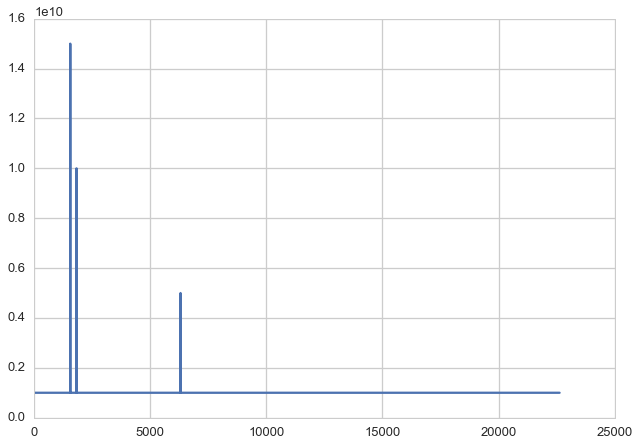

In [7]:
plt.plot(np.diff(coords.index))

### Okay, let's resample with 1 sec intevals and fill up with NaN

In [8]:
coords = coords.resample('1S').asfreq()
coords.loc[coords.ele.isnull()].head()

,ele,idx,lat,lon
2016-06-26 04:57:17,NaN,NaN,NaN,NaN
2016-06-26 04:57:18,NaN,NaN,NaN,NaN
2016-06-26 04:57:19,NaN,NaN,NaN,NaN
2016-06-26 04:57:20,NaN,NaN,NaN,NaN
2016-06-26 04:57:21,NaN,NaN,NaN,NaN


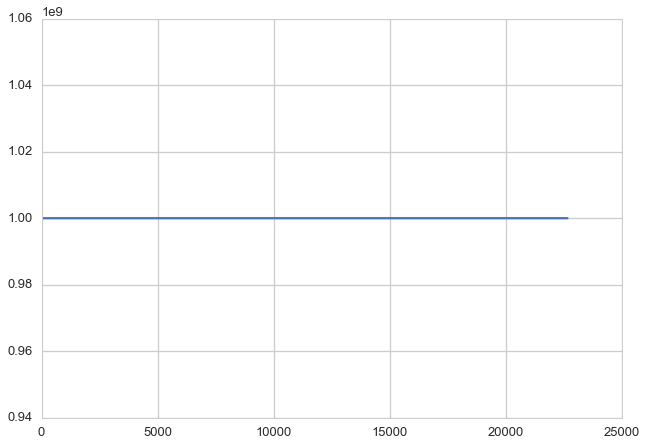

In [9]:
plt.plot(np.diff(coords.index))

### Almost done. Now convert to good old numpy array and mask NaNs

In [10]:
measurements = np.ma.masked_invalid(coords[['lon', 'lat', 'ele']].values)

### So where did I lose the GPS signal?

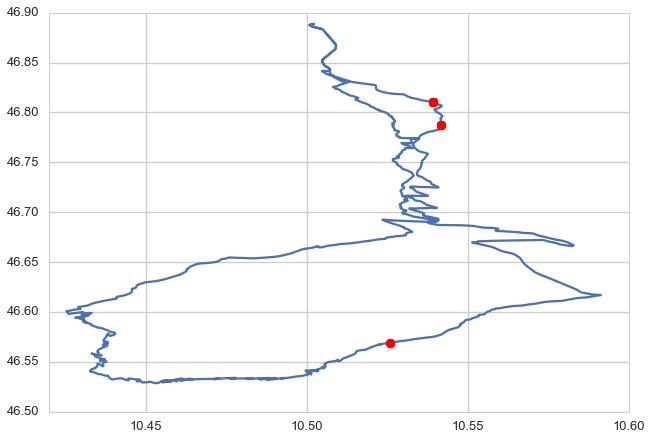

In [11]:
fig = plt.figure()
plt.plot(measurements[:,0], measurements[:,1])
filled_coords = coords.fillna(method='pad').ix[coords.ele.isnull()]
plt.plot(filled_coords['lon'].values, filled_coords['lat'].values, 'ro')

### Let's set up the Kalman Filter

In [87]:
F = np.array([[1, 0, 0, 1, 0, 0],
              [0, 1, 0, 0, 1, 0],
              [0, 0, 1, 0, 0, 1],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1]])

H = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0]])

initial_state_mean = np.hstack([measurements[0, :], 3*[0]])
initial_state_covariance = np.diag([1e-3, 1e-3, 100, 1e-4, 1e-4, 1e-4])**2
observation_covariance = np.diag([1e-3, 1e-3, 100])**2

In [88]:
kf = KalmanFilter(transition_matrices=F, 
                  observation_matrices=H, 
                  initial_state_mean=initial_state_mean,
                  initial_state_covariance=initial_state_covariance,
                  observation_covariance=observation_covariance,
                  em_vars=['transition_covariance'])

In [89]:
kf = kf.em(measurements, n_iter=100)

In [90]:
np.sqrt(kf.observation_covariance)

array([[  1.00000000e-03,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   1.00000000e-03,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+02]])

In [91]:
kf.transition_covariance

array([[  3.17238147e-07,  -1.57848098e-07,  -7.34902714e-07,
          2.27096204e-07,  -3.19503991e-07,  -9.66876128e-07],
       [  1.57851466e-07,   3.17225770e-07,   5.04348254e-07,
          3.19504628e-07,   2.27077728e-07,   9.20019542e-08],
       [ -4.46785827e-08,   8.85708296e-07,   9.52799780e-01,
          4.32046523e-07,   8.87301883e-07,   1.90401065e-03],
       [  2.97619529e-07,  -8.74440314e-08,  -5.55312374e-07,
          5.55226990e-07,  -5.50359559e-07,  -1.86779960e-06],
       [  8.74482292e-08,   2.97601357e-07,   5.59178951e-07,
          5.50359737e-07,   5.55193088e-07,   5.09744382e-07],
       [ -1.81625627e-07,   7.46920526e-07,   1.90452925e-03,
          4.92093226e-07,   1.87248661e-06,   8.04219476e-02]])

### Compare now our measurements with a smoothed track

In [92]:
smoothed_state_means, _ = kf.smooth(measurements)

In [ ]:
smoothed_state_means, _ = kf.smooth(smoothed_state_means[:,:3])

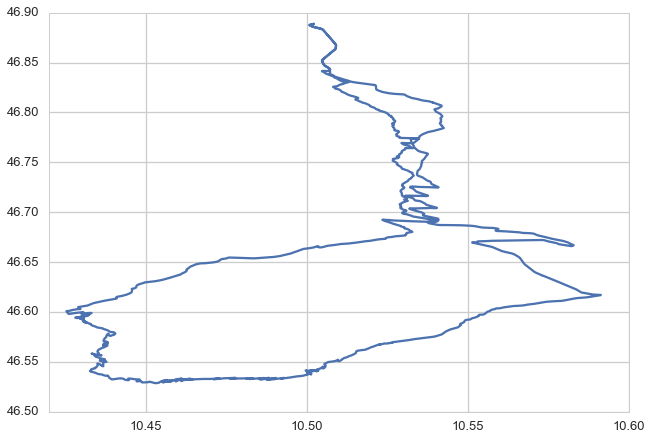

In [93]:
plt.plot(measurements[:,0], measurements[:,1])

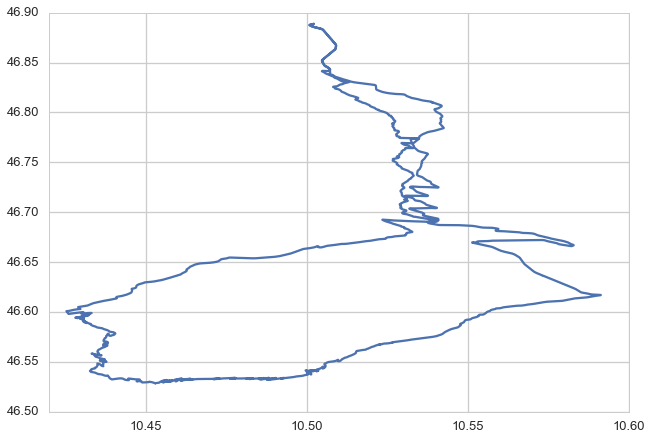

In [94]:
plt.plot(smoothed_state_means[:,0], smoothed_state_means[:,1])

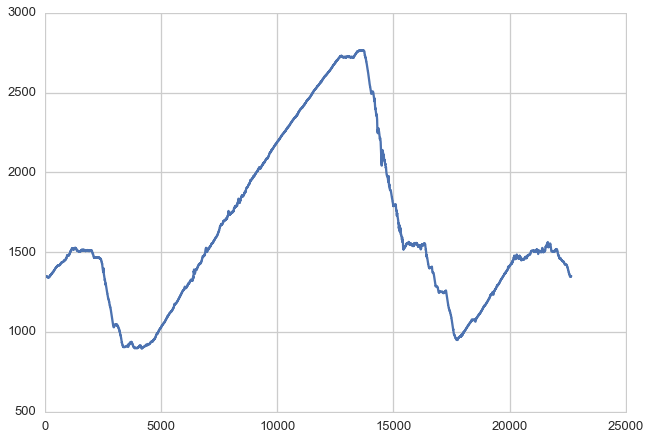

In [95]:
plt.plot(measurements[:,2])

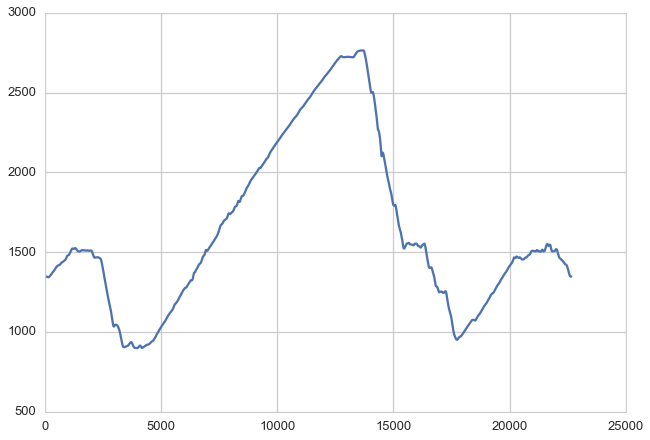

In [96]:
plt.plot(smoothed_state_means[:,2])

### Let's write the smoothed data back into our dataframe and GPX file

In [97]:
coords.ix[:, ['lon', 'lat', 'ele']] = smoothed_state_means[:,:3]
orig_coords = coords.ix[~coords['idx'].isnull()].set_index('idx')

In [98]:
for i, p in enumerate(segment.points):
    p.speed = None
    p.elevation = orig_coords.at[float(i),'ele']
    p.longitude = orig_coords.at[float(i),'lon']
    p.latitude = orig_coords.at[float(i),'lat']

In [99]:
segment.get_uphill_downhill()

UphillDownhill(uphill=2956.4619089681555, downhill=2956.5557209633034)

### Yes, that sounds much more realistic!!! Let's also check the speed

In [100]:
segment.points[0].speed = 0.0
segment.points[-1].speed = 0.0
gpx_file.add_missing_speeds()

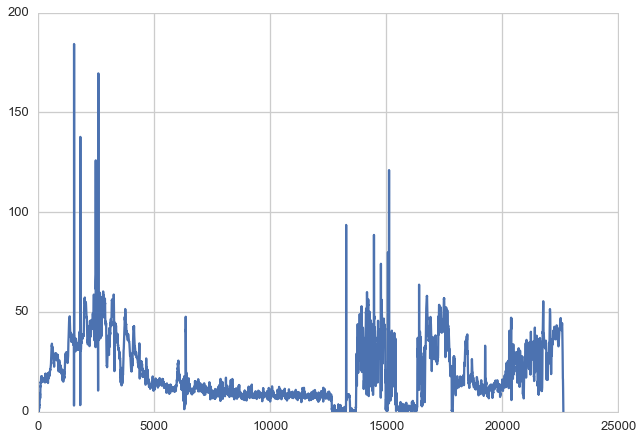

In [101]:
speed = np.array([p.speed for p in segment.points])*3.6
plt.plot(speed)